In [1]:
from parser import *
from config_parser import *

# Получение списка товаров с помощью WB API

In [ ]:
api_df = WB_Parser.get_wb_products(query="миостимулятор",pages=100)
api_df.to_csv("../data/wb_products.csv", index=False)
print(f"Собрано {len(api_df)} товаров")

Собрано 6000 товаров


# Фильтрация данных

In [11]:
api_df = pd.read_csv("../data/wb_products.csv")
api_df

,id,name,price,rating,feedbacks,brand
0,397455530,Массажер миостимулятор для тела пресса спины ш...,1278.0,4.7,71,eFlow
1,221329577,Миостимулятор 36 программ антицеллюлитный для ...,2052.0,4.9,1021,NaN
2,334678554,Миостимулятор 48 программ массажер для похудения,4196.0,4.9,1021,NaN
3,359420749,Миостимулятор для тела антицеллюлитный для пох...,1945.0,4.9,13,NaN
4,221352035,Миостимулятор 36 программ массажер для похудения,1847.0,4.9,1021,NaN
...,...,...,...,...,...,...
5995,384483737,Косметологический аппарат B-333,11551.0,0.0,0,NaN
5996,248314031,Массажер FH-320 цвета в ассортименте,1332.0,0.0,0,Isa
5997,237927173,Массажер для шеи и плеч KL-5830 микротоковый,1839.0,0.0,0,Neck Massager
5998,237927166,Массажер для шеи и плеч KL-5830,2016.0,0.0,0,Neck Massager


In [ ]:
# Первичный фильтр 
exclude_patterns = [
    r"электрод", r"шнур", r"кабель", r"провод", 
    r"пластин", r"гель",
    r"крепеж", r"держатель", r"запчасть",
    r"аксессуар", r"led"#, r"подставка"
]

# Фильтрация нерелевантных товаров
def is_relevant(name):
    if pd.isna(name):
        return False
  
    name = name.lower()
    
    if any(re.search(pattern, name) for pattern in exclude_patterns):
        return False
   
    # return any(re.search(kw, name) for kw in include_keywords)
    return True

mask = api_df['name'].apply(is_relevant)
clear_df = api_df[mask].copy()

# 1. Удалить товары без отзывов
clear_df = clear_df[clear_df['feedbacks'] > 0]

# 2. Рассчитать пороги для ценовых сегментов
price_25 = clear_df['price'].quantile(0.25)
price_75 = clear_df['price'].quantile(0.75)
feedback_median = clear_df['feedbacks'].median()

# 3. Отобрать топ-20% по отзывам?
top_20_percent = clear_df[clear_df['feedbacks'] >= clear_df['feedbacks'].quantile(0.8)]

# 4. Сбалансированные выборки по ценовым сегментам
low_price = clear_df[clear_df['price'] < price_25].nlargest(30, 'feedbacks')
mid_price = clear_df[(clear_df['price'] >= price_25) & (clear_df['price'] <= price_75)].nlargest(30, 'feedbacks')
high_price = clear_df[clear_df['price'] > price_75].nlargest(30, 'feedbacks')

# 5. Недооцененные товары с высоким рейтингом
undervalued = clear_df[
    (clear_df['rating'] >= 4.8) & 
    (clear_df['price'] < clear_df['price'].median()) & 
    (clear_df['feedbacks'] < feedback_median)
].nlargest(20, 'rating')

# Объединить все отобранные товары
final_ids = pd.concat([
    top_20_percent,
    low_price,
    mid_price,
    high_price,
    undervalued
])['id'].drop_duplicates()

clear_df = api_df[api_df["id"].isin(final_ids)]

clear_df.to_csv("../data/cleared_wb_products.csv", index=False)

In [2]:
clear_df = pd.read_csv("../data/cleared_wb_products.csv")

In [14]:
clear_df["price"].describe()

count      357.000000
mean      2487.156863
std       3346.196735
min        141.000000
25%        680.000000
50%       1423.000000
75%       2867.000000
max      36023.000000
Name: price, dtype: float64

In [4]:
clear_df

,id,name,price,rating,feedbacks,brand
0,221329577,Миостимулятор 36 программ антицеллюлитный для ...,2052.0,4.9,1021,NaN
1,334678554,Миостимулятор 48 программ массажер для похудения,4196.0,4.9,1021,NaN
2,221352035,Миостимулятор 36 программ массажер для похудения,1847.0,4.9,1021,NaN
3,91028354,Миостимулятор массажер импульсный электрически...,2543.0,4.6,561,AShop
4,169351017,"Миостимулятор FZ-1 ""ШУБОШИ"" для мышц",3986.0,4.9,365,SHUBOSHI
...,...,...,...,...,...,...
352,354637348,Косметический микротоковый вибромассажер для лица,1359.0,4.6,600,Dimarket
353,239568299,Подставка для микротокового аппарата массажера...,352.0,4.8,413,Kirei Tech
354,405657557,Микротоковый роликовый массажер роллер для лица,2459.0,4.7,217,NaN
355,14568528,Массажёр для шеи ног спины плеч и тела,1500.0,4.7,12804,Массажер Showerli


# Получение описания и характеристик товаров

In [2]:
def write_lock_df_to_file(path, df, write_lock):
    with write_lock:
        try:
            if not os.path.exists(path):
                df.to_csv(path, index=False)
            else:
                df.to_csv(path, mode='a', header=False, index=False) 
            logging.debug(f"Успешная запись в файл!")
        except Exception as e:
            logging.error(f"Ошибка записи в файл: {e}")

In [3]:
write_lock = Lock()

def batch_parse_details(product_ids, main_details_file, other_specs_file):
    logging.info(f"Инициализация драйвера для группы из {len(product_ids)} артикулов")
    batch_results_main = []
    batch_results_specs = []

    try:
        with WB_Parser() as parser:
            for id in product_ids:
                try:
                    product_data = parser.get_product_details(id)
                    current_main_df, current_specs_df = parse_product_data(product_data)
                    if not current_main_df.empty:
                        batch_results_main.append(current_main_df)
                    if not current_specs_df.empty:
                        batch_results_specs.append(current_specs_df)
                    delay = random.uniform(0.5, 1)
                    time.sleep(delay)
                except Exception as e:
                    logging.error(f"Ошибка при обработке {id}: {str(e)}")
            
            if batch_results_main:
                batch_main_df = pd.concat(batch_results_main, ignore_index=True)
                write_lock_df_to_file(main_details_file, batch_main_df, write_lock)

            if batch_results_specs:  
                batch_specs_df = pd.concat(batch_results_specs, ignore_index=True)
                write_lock_df_to_file(other_specs_file, batch_specs_df, write_lock)
        
    finally:
        logging.info(f"Драйвер для группы завершил работу")

In [4]:
df_id = pd.read_csv("../data/cleared_wb_products.csv")
df_id = df_id["id"].to_list()[:50]

MAIN_DETAILS_FILE = "main_details.csv"
SPECS_FILE = "specs_details.csv"

for f in [MAIN_DETAILS_FILE, SPECS_FILE]:
    if os.path.exists(f):
        os.remove(f)

# Настройки потоков
NUM_THREADS = 5  # Количество одновременно работающих драйверов
BATCH_SIZE = 10   # Количество артикулов на один драйвер

# Разбиваем артикулы на группы
batches = [df_id[i:i + BATCH_SIZE] for i in range(0, len(df_id), BATCH_SIZE)]
print(f"Всего артикулов: {len(df_id)} | Групп: {len(batches)} | Размер группы: {BATCH_SIZE}")

Всего артикулов: 50 | Групп: 5 | Размер группы: 10


Классический запуск:

In [ ]:
with ThreadPoolExecutor(NUM_THREADS=NUM_THREADS) as executor:
    for batch in batches:
        executor.submit(batch_parse_details, batch, MAIN_DETAILS_FILE, SPECS_FILE)

print(f"\nПарсинг завершен! Результаты сохранены в {MAIN_DETAILS_FILE}, {SPECS_FILE}")

Асинхронный запуск:

In [5]:
import asyncio
import nest_asyncio
from tqdm.notebook import tqdm

nest_asyncio.apply()  # Важно для Jupyter!

async def run_async_parsing():
    pbar = tqdm(total=len(batches), desc="Обработка батчей")
    with ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
        loop = asyncio.get_running_loop()
        tasks = []

        for batch in batches:
            # Запускаем синхронную функцию в потоке
            task = loop.run_in_executor(
                executor,
                batch_parse_details,
                batch,
                MAIN_DETAILS_FILE,
                SPECS_FILE
            )
            tasks.append(task)
        
        # Ожидаем завершения всех задач
        # await asyncio.gather(*tasks)
        for future in asyncio.as_completed(tasks):
            await future
            pbar.update(1)  # Обновляем прогресс после каждого завершенного батча
            pbar.set_postfix({"Активных задач": f"{len(tasks) - pbar.n}/{len(tasks)}"})
        
        pbar.close()

# Запуск в фоне
parsing_task = asyncio.create_task(run_async_parsing())
print("Парсинг запущен в фоне!")

Парсинг запущен в фоне!


Обработка батчей:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
print("Hello async")

Hello async


In [7]:
final_main_df = pd.read_csv("main_details.csv")
merged_main_df = pd.merge(
    clear_df,
    final_main_df,
    left_on="id",
    right_on="id",
    how='right'
)
merged_main_df.head(3)
print(len(merged_main_df))

50


In [118]:
merged_main_df.to_csv("../data/details_cleared_wb_products.csv", index=False)

In [15]:
final_specs_df = pd.read_csv("specs_details.csv")
final_specs_df

,good_id,group_name,name,value
0,221329577,Основная информация,Цвет,серебристый
1,221329577,Общие характеристики,Гарантийный срок,12 месяцев
2,221329577,Питание,Питание,USB; от аккумулятора
3,221329577,Технические особенности,Количество режимов работы,36 режимов
4,221329577,Насадки,Количество насадок,10 шт.
...,...,...,...,...
862,250133162,Дополнительная информация,Страна производства,Китай
863,250133162,Габариты,Вес с упаковкой (кг),0.3 кг
864,250133162,Габариты,Длина упаковки,15 см
865,250133162,Габариты,Высота упаковки,8 см


In [119]:
final_specs_df.to_csv("../data/other_specs_cleared_wb_products.csv", index=False)

# Парсинг отзывов

In [8]:
from threading import Lock
import os
write_lock = Lock()

# Функция для обработки группы артикулов одним драйвером
def process_product_batch(product_ids, output_file):
    logging.info(f"Инициализация драйвера для группы из {len(product_ids)} артикулов")
    batch_results = []
    
    try:
        with WB_Parser() as parser:
            for id in product_ids:
                try:
                    feedback_df = parser.get_product_feedbacks(id)
                    if not feedback_df.empty:
                        batch_results.append(feedback_df)
                    # Пауза между запросами
                    time.sleep(1)
                except Exception as e:
                    logging.error(f"Ошибка при обработке {id}: {str(e)}")
            
            if batch_results:
                batch_df = pd.concat(batch_results, ignore_index=True)
                write_lock_df_to_file(output_file, batch_df, write_lock)
                logging.info(f"Группа из {len(product_ids)} артикулов обработана. Отзывов: {len(batch_df)}")
            else:
                logging.info(f"Группа из {len(product_ids)} артикулов не содержит отзывов")
    finally:
        logging.info(f"Драйвер для группы завершил работу")

In [9]:
df_id = pd.read_csv("../data/cleared_wb_products.csv")
df_id = df_id["id"].to_list()[:5]

OUTPUT_FILE = "all_feedbacks.csv"

if os.path.exists(OUTPUT_FILE):
        os.remove(OUTPUT_FILE)

# Настройки потоков
NUM_THREADS = 5  # Количество одновременно работающих драйверов
BATCH_SIZE = 1   # Количество артикулов на один драйвер

# Разбиваем артикулы на группы
batches = [df_id[i:i + BATCH_SIZE] for i in range(0, len(df_id), BATCH_SIZE)]
print(f"Всего артикулов: {len(df_id)} | Групп: {len(batches)} | Размер группы: {BATCH_SIZE}")

Всего артикулов: 5 | Групп: 5 | Размер группы: 1


Классический запуск:

In [ ]:
# Запускаем обработку группами
with ThreadPoolExecutor(NUM_THREADS=NUM_THREADS) as executor:
    for batch in batches:
        executor.submit(process_product_batch, batch, OUTPUT_FILE)

logging.info(f"Парсинг завершен! Результаты сохранены в {OUTPUT_FILE}")
print("Парсинг завершен! Результаты сохранены в", OUTPUT_FILE)

Парсинг завершен! Результаты сохранены в all_feedbacks.csv


Асинхронный запуск:

In [10]:
import asyncio
import nest_asyncio
from tqdm.notebook import tqdm

nest_asyncio.apply()

async def run_async_parsing():
    pbar = tqdm(total=len(batches), desc="Обработка батчей")
    with ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
        loop = asyncio.get_running_loop()
        tasks = []

        for batch in batches:
            # Запускаем синхронную функцию в потоке
            task = loop.run_in_executor(
                executor,
                process_product_batch,
                batch,
                OUTPUT_FILE
            )
            tasks.append(task)
        
        # Ожидаем завершения всех задач
        # await asyncio.gather(*tasks)
        for future in asyncio.as_completed(tasks):
            await future
            pbar.update(1)  # Обновляем прогресс после каждого завершенного батча
            pbar.set_postfix({"Активных задач": f"{len(tasks) - pbar.n}/{len(tasks)}"})
        
        pbar.close()

# Запуск в фоне
parsing_task = asyncio.create_task(run_async_parsing())
print("Парсинг запущен в фоне!")

Парсинг запущен в фоне!


Обработка батчей:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
feedbacks = pd.read_csv("all_feedbacks.csv")

5

Итоговое количество товаров с отзывами 333, тк не для всех вариантов товара есть отзывы с текстом

In [ ]:
clear_df[~clear_df["id"].isin(feedbacks["product_id"].unique())]

len(feedbacks["product_id"].unique())


333

# Получение данных Ozon

In [18]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

OUTPUT_FILE_OZON_PRODUCTS = "ozon_products.csv"

def parse_ozon_products(output_file):
    with Ozon_Parser() as parser:
        links_df = parser.get_products_links()
    links_df.to_csv(output_file, index=False)

async def run_async_parsing():

    loop = asyncio.get_running_loop()
    
    # Правильное использование run_in_executor
    await loop.run_in_executor(
        None,
        parse_ozon_products,
        OUTPUT_FILE_OZON_PRODUCTS
    )


parsing_task = asyncio.create_task(run_async_parsing())
print("Парсинг запущен в фоне!")


Парсинг запущен в фоне!


In [24]:
if parsing_task.done():
    print("Парсинг завершен")
else:
    print("Парсинг еще в процессе")

Парсинг завершен


In [ ]:
with Ozon_Parser() as parser:
        links_df = parser.get_products_links()

# Анализ данных
## 1. Распределение цен

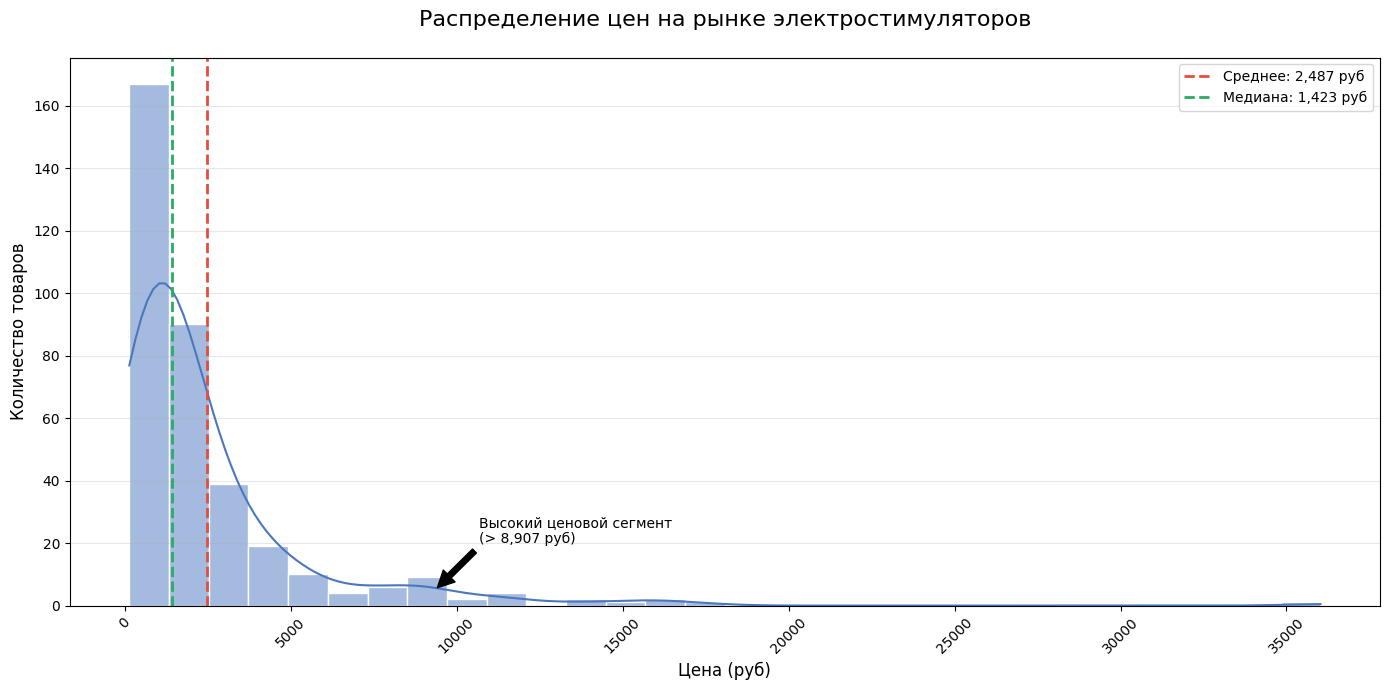

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

price_data = clear_df["price"]

plt.figure(figsize=(14, 7))

ax = sns.histplot(price_data, bins=30, kde=True, 
                 color='#4B77BE', edgecolor='white')

mean_price = price_data.mean()
median_price = price_data.median()

plt.axvline(mean_price, color='#E74C3C', linestyle='--', 
           linewidth=2, label=f'Среднее: {mean_price:,.0f} руб')
plt.axvline(median_price, color='#27AE60', linestyle='--',
           linewidth=2, label=f'Медиана: {median_price:,.0f} руб')

q95 = price_data.quantile(0.95)
outliers = price_data[price_data > q95]
if len(outliers) > 0:
    plt.annotate(f'Высокий ценовой сегмент\n(> {q95:,.0f} руб)',
                xy=(q95*1.05, 5), xytext=(q95*1.2, 20),
                arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Распределение цен на рынке электростимуляторов\n', fontsize=16)
plt.xlabel('Цена (руб)', fontsize=12)
plt.ylabel('Количество товаров', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Набольшая часть популярных товаров представлена в ценовом сегменте до 5000

## 2. Распределение цены без выбросов 

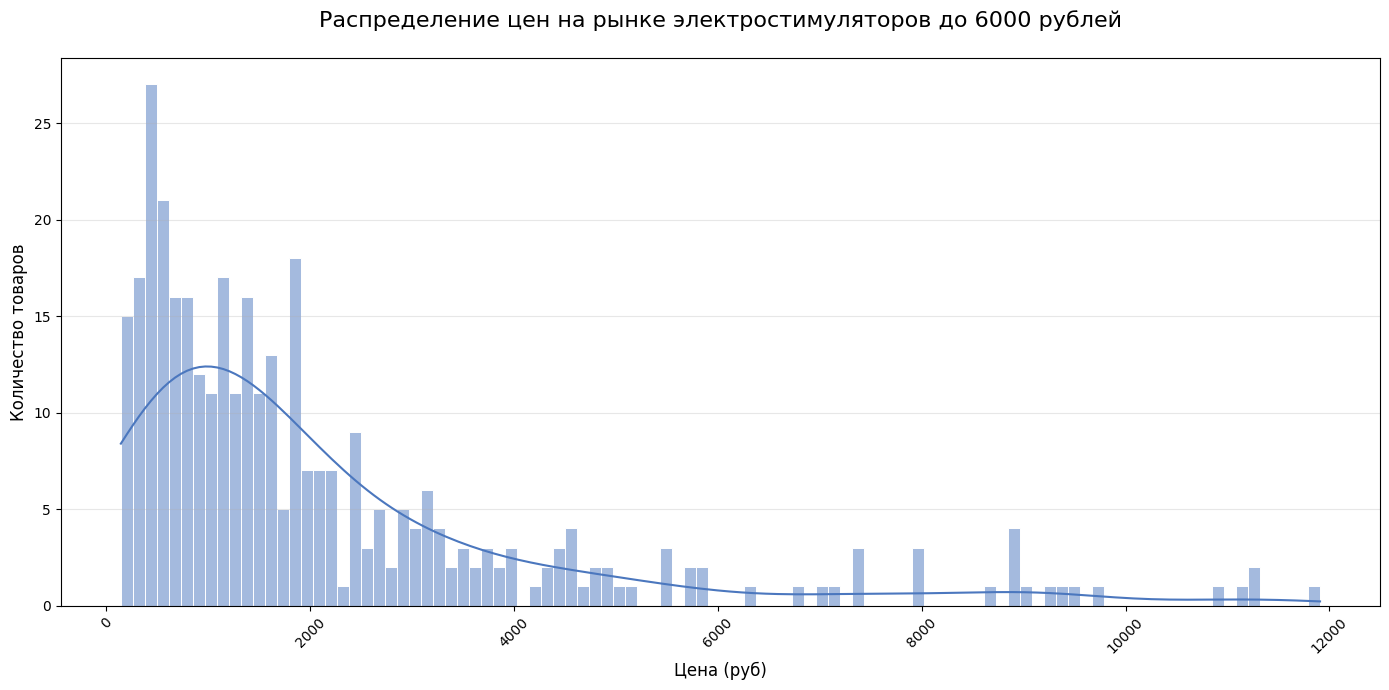

In [248]:
import matplotlib.pyplot as plt
import seaborn as sns

price_data = clear_df[clear_df["price"] <= clear_df["price"].mean() + 3 * clear_df["price"].std()]["price"]

plt.figure(figsize=(14, 7))
ax = sns.histplot(price_data, bins=100, kde=True,
                 color='#4B77BE', edgecolor='white')

mean_price = price_data.mean()
median_price = price_data.median()

plt.title('Распределение цен на рынке электростимуляторов до 6000 рублей\n', fontsize=16)
plt.xlabel('Цена (руб)', fontsize=12)
plt.ylabel('Количество товаров', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Основные метрики

In [249]:
stats = {
    'Средняя цена': f"{price_data.mean():,.0f} руб",
    'Медианная цена': f"{price_data.median():,.0f} руб",
    'Минимальная цена': f"{price_data.min():,.0f} руб",
    'Максимальная цена': f"{price_data.max():,.0f} руб",
    'Стандартное отклонение': f"{price_data.std():,.0f} руб",
    '95-й перцентиль': f"{price_data.quantile(0.95):,.0f} руб"
}

print("Ключевые метрики распределения цен:")
for k, v in stats.items():
    print(f"{k}: {v}")

Ключевые метрики распределения цен:
Средняя цена: 2,170 руб
Медианная цена: 1,410 руб
Минимальная цена: 141 руб
Максимальная цена: 11,909 руб
Стандартное отклонение: 2,280 руб
95-й перцентиль: 7,688 руб


Попробуем разбить товары на ценовые категории по квартилям:

In [250]:
print(clear_df["price"].quantile(0.25), clear_df["price"].quantile(0.5), clear_df["price"].quantile(0.75))


680.0 1423.0 2867.0


Однако наше распределение имеет слишком большой разброс, сильное смещение в сторону нулевой цены и длинный хвост. Поэтому для лучшего учета рыночных реалий, попробуем разбить нашу выборку на 4 ценовые категории (низкая, средняя, средне-высокая и высокая) с помощью метода KMeans 

In [6]:
from sklearn.cluster import KMeans

clear_df = pd.read_csv("../data/cleared_wb_products.csv")

# Ограничим сильные выбросы 3 сигмами
price_segment_clear_df = clear_df[clear_df["price"] <= clear_df["price"].mean() + 3 * clear_df["price"].std()]

prices = price_segment_clear_df["price"].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=4, random_state=42).fit(prices)
price_segment_clear_df['price_segment'] = kmeans.labels_

/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_32780/1453602710.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_segment_clear_df['price_segment'] = kmeans.labels_


In [7]:
def min_max(price_segment, df):
    return df[df["price_segment"] == price_segment]["price"].min(), df[df["price_segment"] == price_segment]["price"].max()

print(f"Низкий ценовой сегмент: {min_max(0, price_segment_clear_df)}")
print(f"Средний ценовой сегмент: {min_max(3, price_segment_clear_df)}")
print(f"Средне-высокий ценовой сегмент:{min_max(2, price_segment_clear_df)}")
print(f"Высокий ценовой сегмент:  {min_max(1, price_segment_clear_df)}")

# clear_df[clear_df["price_segment"] == 0]

Низкий ценовой сегмент: (141.0, 1456.0)
Средний ценовой сегмент: (1463.0, 3272.0)
Средне-высокий ценовой сегмент:(3405.0, 6300.0)
Высокий ценовой сегмент:  (6789.0, 11909.0)


In [8]:
price_segment_clear_df

,id,name,price,rating,feedbacks,brand,price_segment
0,221329577,Миостимулятор 36 программ антицеллюлитный для ...,2052.0,4.9,1021,NaN,3
1,334678554,Миостимулятор 48 программ массажер для похудения,4196.0,4.9,1021,NaN,2
2,221352035,Миостимулятор 36 программ массажер для похудения,1847.0,4.9,1021,NaN,3
3,91028354,Миостимулятор массажер импульсный электрически...,2543.0,4.6,561,AShop,3
4,169351017,"Миостимулятор FZ-1 ""ШУБОШИ"" для мышц",3986.0,4.9,365,SHUBOSHI,2
...,...,...,...,...,...,...,...
352,354637348,Косметический микротоковый вибромассажер для лица,1359.0,4.6,600,Dimarket,0
353,239568299,Подставка для микротокового аппарата массажера...,352.0,4.8,413,Kirei Tech,0
354,405657557,Микротоковый роликовый массажер роллер для лица,2459.0,4.7,217,NaN,3
355,14568528,Массажёр для шеи ног спины плеч и тела,1500.0,4.7,12804,Массажер Showerli,3


In [9]:
details_cleared_df = pd.read_csv("../data/details_cleared_wb_products.csv")
price_segment_clear_df = pd.merge(
    price_segment_clear_df,
    details_cleared_df[["id", "power_type", "zones", "description"]],
    left_on="id",
    right_on="id",
    how='left'
)

In [10]:
other_specs =  pd.read_csv("../data/other_specs_cleared_wb_products.csv")

In [11]:
other_specs.head(5)

,good_id,group_name,name,value
0,221329577,Основная информация,Цвет,серебристый
1,221329577,Общие характеристики,Гарантийный срок,12 месяцев
2,221329577,Питание,Питание,USB; от аккумулятора
3,221329577,Технические особенности,Количество режимов работы,36 режимов
4,221329577,Насадки,Количество насадок,10 шт.


In [12]:
new_df = pd.merge(
    price_segment_clear_df,
    other_specs,
    left_on="id",
    right_on="good_id",
    how='right'
)

new_df = new_df[new_df['name_y'].str.contains('тип', case=False, na=False)]
new_df = new_df.rename(columns={
    'name_x': 'name',
    'value' : 'type'
    })
new_df = new_df.drop(['good_id', 'group_name', 'name_y'], axis=1)

new_df.head(1)

,id,name,price,rating,feedbacks,brand,price_segment,power_type,zones,description,type
5,221329577.0,Миостимулятор 36 программ антицеллюлитный для ...,2052.0,4.9,1021.0,NaN,3.0,USB; от аккумулятора,ноги; спина; тело,Импульсный массажер – это высокотехнологичный ...,электроимпульсный; вибромассажер


In [13]:
price_segment_clear_df = new_df
price_segment_clear_df.head(1)

,id,name,price,rating,feedbacks,brand,price_segment,power_type,zones,description,type
5,221329577.0,Миостимулятор 36 программ антицеллюлитный для ...,2052.0,4.9,1021.0,NaN,3.0,USB; от аккумулятора,ноги; спина; тело,Импульсный массажер – это высокотехнологичный ...,электроимпульсный; вибромассажер


In [24]:
def price_analys_segment(segment_df, top_n):
    print(f"Кол-во товаров в этом сегменте: {len(segment_df)}")
    print(f"Топ 5 брендов:\n{segment_df['brand'].value_counts().head(10)}")
    print(f"Доля товаров без бренда: {len(segment_df[segment_df['brand'].isna()]) / len(segment_df)}")
    print(f"Средний рейтинг: {segment_df['rating'].median()}")

    zones = segment_df['zones'].str.split('[;,/]', expand=True).stack().str.strip()
    top_zones = zones.value_counts().head(top_n)
    print(top_zones)

    power_type = segment_df['power_type'].str.split('[;,/]', expand=True).stack().str.strip()
    top_power = power_type.value_counts().head(top_n)
    print(top_power)

    type = segment_df['type'].str.split('[;,/]', expand=True).stack().str.strip()
    top_type = type.value_counts().head(top_n)
    print(top_type)

low_price_df = price_segment_clear_df[price_segment_clear_df["price_segment"] == 0]
mid_price_df = price_segment_clear_df[price_segment_clear_df["price_segment"] == 3]
mid_high_price_df = price_segment_clear_df[price_segment_clear_df["price_segment"] == 2]
high_price_df = price_segment_clear_df[price_segment_clear_df["price_segment"] == 1]

top_n = 5
print("Низкий ценовой сегмент:=============================================")
price_analys_segment(low_price_df, top_n)
print("\nСредний ценовой сегмент:=============================================")
price_analys_segment(mid_price_df, top_n)
print("\nСредне-высокий ценовой сегмент:=============================================")
price_analys_segment(mid_high_price_df, top_n)
print("\nВысокий ценовой сегмент:=============================================")
price_analys_segment(high_price_df, top_n)
# low_price_df
price_segment_clear_df.head(3)

Низкий ценовой сегмент:=============================================
Кол-во товаров в этом сегменте: 137
Топ 5 брендов:
brand
000-Art                   6
Массажер электрический    5
Ура, приехало!            4
Chernika                  4
HomelySpa                 4
"ng beauty"               3
FURVIREA                  3
Furellia                  3
classic trends            3
7TON                      3
Name: count, dtype: int64
Доля товаров без бренда: 0.051094890510948905
Средний рейтинг: 4.6
шея      52
тело     47
спина    42
живот    41
ноги     31
Name: count, dtype: int64
USB                            61
от аккумулятора                58
от сети                        46
от батареек                    20
от прикуривателя автомобиля     5
Name: count, dtype: int64
электроимпульсный    91
вибромассажер        52
микротоковый         18
тепловой             16
постукивающий        14
Name: count, dtype: int64

Средний ценовой сегмент:=============================================
Ко

,id,name,price,rating,feedbacks,brand,price_segment,power_type,zones,description,type
5,221329577.0,Миостимулятор 36 программ антицеллюлитный для ...,2052.0,4.9,1021.0,NaN,3.0,USB; от аккумулятора,ноги; спина; тело,Импульсный массажер – это высокотехнологичный ...,электроимпульсный; вибромассажер
23,334678554.0,Миостимулятор 48 программ массажер для похудения,4196.0,4.9,1021.0,NaN,2.0,от аккумулятора,тело,Четырехканальное обезболивание: 4-канальный ст...,электроимпульсный
38,221352035.0,Миостимулятор 36 программ массажер для похудения,1847.0,4.9,1021.0,NaN,3.0,от аккумулятора,тело,Импульсный массажер – это высокотехнологичный ...,электроимпульсный


In [22]:
price_segment_clear_df[price_segment_clear_df['brand'] == "Массажер электрический"]

,id,name,price,rating,feedbacks,brand,price_segment,power_type,zones,description,type
820,399491740.0,Массажер для тела микротоковый,486.0,4.7,753.0,Массажер электрический,0.0,от аккумулятора,тело; мышцы; руки,Микротоковый массажер для тела подойдет для пр...,электроимпульсный
1351,278820954.0,Массажер миостимулятор бабочка,560.0,4.7,753.0,Массажер электрический,0.0,от аккумулятора,спина; тело; мышцы,Миостимулятор бабочка - микротоковый массажер ...,электроимпульсный
1373,340459341.0,Массажер бабочка,412.0,4.7,753.0,Массажер электрический,0.0,от аккумулятора,спина; тело; мышцы,Миостимулятор бабочка со сменными пластинами -...,электроимпульсный
1537,324901316.0,Массажер бабочка с пультом,526.0,4.6,328.0,Массажер электрический,0.0,от аккумулятора,спина; тело; мышцы,Миостимулятор бабочка со сменными пластинами и...,электроимпульсный
2026,372471091.0,Тренажер бабочка с пультом,456.0,4.6,328.0,Массажер электрический,0.0,от аккумулятора,спина; тело; мышцы,Тренажер миостимулятор бабочка со сменными пла...,электроимпульсный


## 3. Зависимость цены от рейтинга 

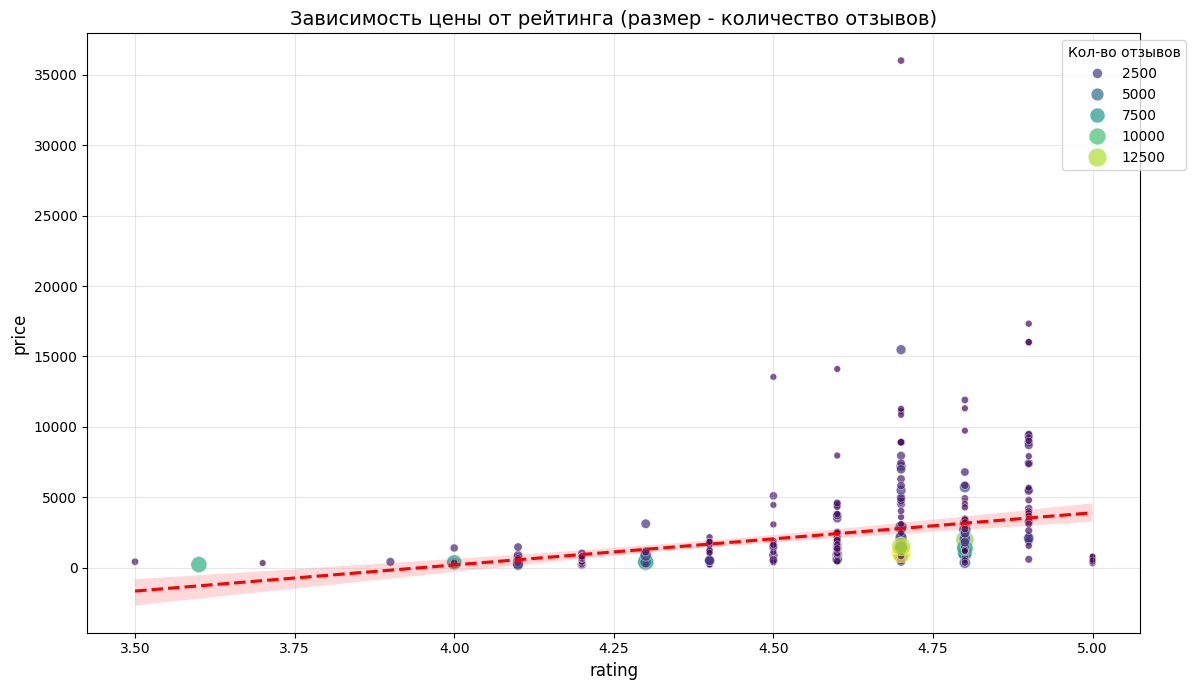

In [ ]:
# P.S. Обновить после подсчета отзывов по каждому конкретному товару

import numpy as np

plt.figure(figsize=(12, 7))
sns.scatterplot(data=clear_df, x='rating', y='price', 
                hue='feedbacks', size='feedbacks',
                sizes=(20, 200), alpha=0.7, palette='viridis')

plt.title('Зависимость цены от рейтинга (размер - количество отзывов)', fontsize=14)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.xticks(np.arange(3.5, 5.1, 0.25))
plt.grid(alpha=0.3)
plt.ticklabel_format(style='plain', axis='y')

# Добавляем линию тренда
sns.regplot(data=clear_df, x='rating', y='price', 
           scatter=False, color='red', line_kws={'linestyle':'--'})

plt.legend(title='Кол-во отзывов', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

Электростимуляторы более дорогой ценовой категории получают рейтинг выше и пользуются большей популярностью

### Распределение цен в разных рейтинговых группах

/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_16958/1485641326.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clear_df['rating_group'] = pd.cut(clear_df['rating'],
/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_16958/1485641326.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clear_df, x='rating_group', y='price',
/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_16958/1485641326.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

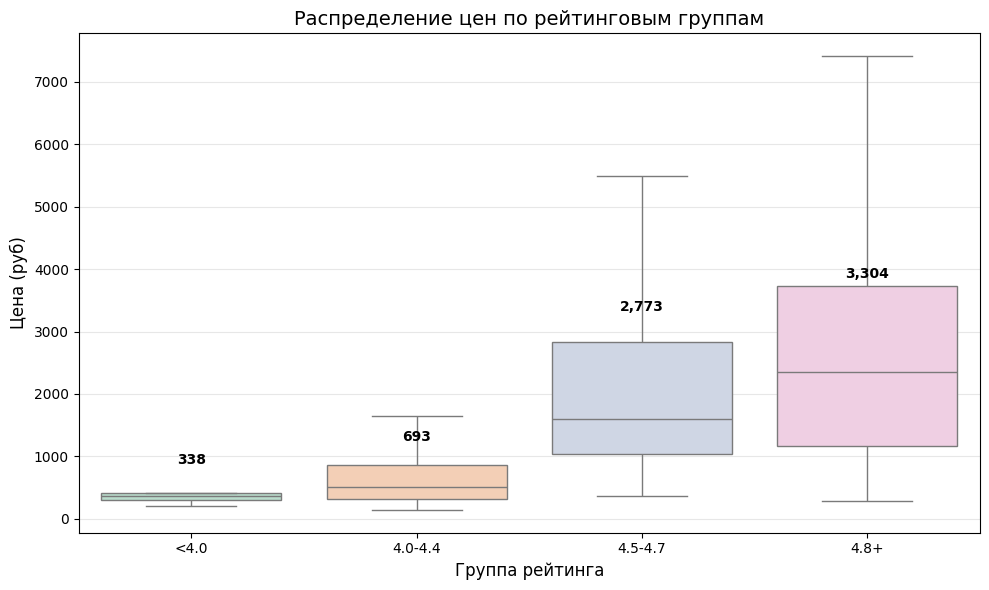

In [ ]:
#

plt.figure(figsize=(10, 6))

# Создаем рейтинговые группы
clear_df['rating_group'] = pd.cut(clear_df['rating'], 
                                   bins=[0, 3.9, 4.4, 4.7, 5],
                                   labels=['<4.0', '4.0-4.4', '4.5-4.7', '4.8+'])

sns.boxplot(data=clear_df, x='rating_group', y='price', 
           palette='Pastel2', showfliers=False)

plt.title('Распределение цен по рейтинговым группам', fontsize=14)
plt.xlabel('Группа рейтинга', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Добавляем средние значения
means = clear_df.groupby('rating_group')['price'].mean()
for i, mean in enumerate(means):
    plt.text(i, mean+500, f'{mean:,.0f}', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Ящик с усами цен по брендам

/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_16958/3759864018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['brand'] = boxplot_df['brand'].str.strip().str.title()
/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_16958/3759864018.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


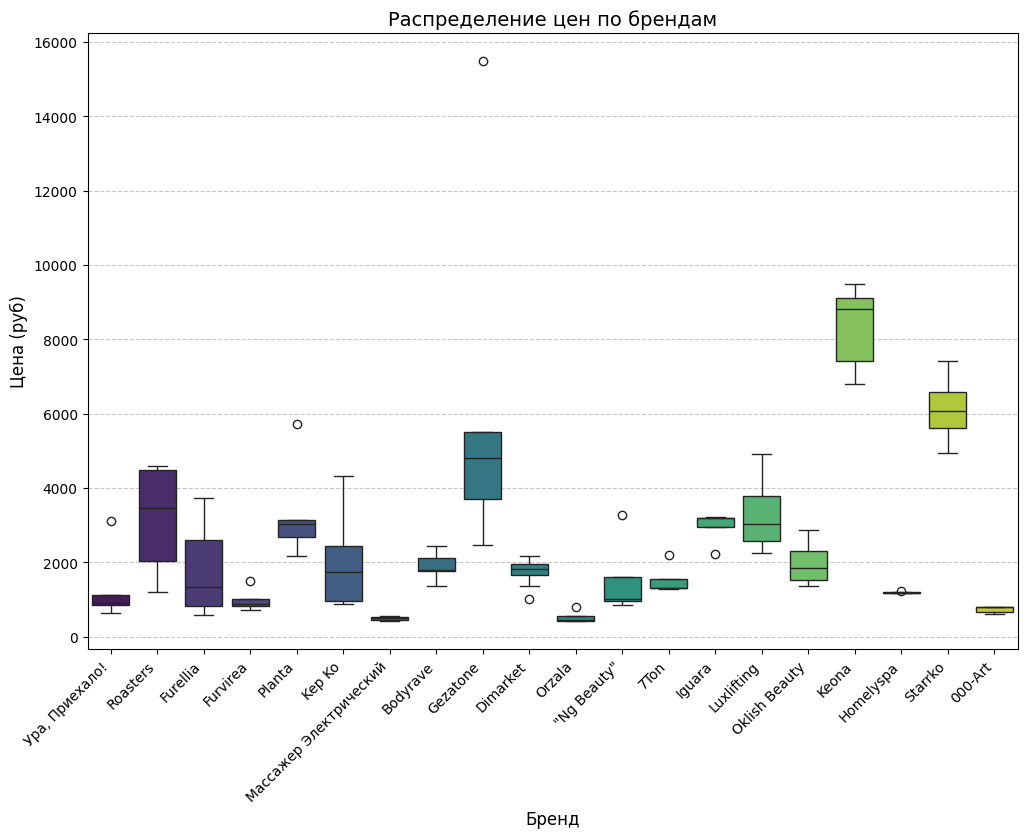

In [ ]:
# Boxplot по брендам

boxplot_df = clear_df.dropna(subset=["brand"])
boxplot_df['brand'] = boxplot_df['brand'].str.strip().str.title()

top_brands = boxplot_df['brand'].value_counts().head(20).index  # Топ-20 брендов
df_filtered = boxplot_df[boxplot_df['brand'].isin(top_brands)]

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_filtered,
    x='brand',
    y='price',
    palette='viridis'
)
plt.title('Распределение цен по брендам', fontsize=14)
plt.xlabel('Бренд', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Поворот подписей
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 5. Анализ текстов отзывов
### Подготовка текстов

In [27]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nekitmilk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
# Загрузка данных
df = pd.read_csv('../data/all_feedbacks.csv')

In [29]:
# Функция очистки текста
def clean_text(text):
    if pd.isna(text): 
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Удаление пунктуации
    text = re.sub(r'\d+', '', text)       # Удаление цифр
    # Удаление стоп-слов и стемминг
    stop_words = set(stopwords.words('russian'))
    stemmer = SnowballStemmer('russian')
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words and len(word) > 2]
    return " ".join(words)


df['advantage'] = df['advantage'].str.replace(r'^Достоинства:\s*', '', regex=True)
df['disadvantage'] = df['disadvantage'].str.replace(r'^Недостатки:\s*', '', regex=True)
df['comment'] = df['comment'].str.replace(r'^Комментарий:\s*', '', regex=True)
df['full_text'] = (
    df['advantage'].fillna('') + " " + 
    df['disadvantage'].fillna('') + " " +
    df['comment'].fillna('')
)

# Очистка колонок
df['advantage_clean'] = df['advantage'].apply(clean_text)
df['disadvantage_clean'] = df['disadvantage'].apply(clean_text)
df['comment_clean'] = df['comment'].apply(clean_text)

df['full_text_clean'] = df['full_text'].apply(clean_text)

In [30]:
df.head(5)

,product_id,rating,advantage,disadvantage,comment,full_text,advantage_clean,disadvantage_clean,comment_clean,full_text_clean
0,269273309,5,"Не знаю будет ли толк, привыкаю постепенно, из...",NaN,NaN,"Не знаю будет ли толк, привыкаю постепенно, из...",зна толк привыка постепен изначальн выдержива ...,,,зна толк привыка постепен изначальн выдержива ...
1,269273309,1,NaN,После зарядка аккумулятора на табло НЕ ВЫСВЕЧИ...,Прошу вернуть деньги.,После зарядка аккумулятора на табло НЕ ВЫСВЕЧ...,,зарядк аккумулятор табл высвечива символ knead,прош вернут деньг,зарядк аккумулятор табл высвечива символ knead...
2,269273309,3,NaN,Мятая и рваная упаковка,"В деле не пробовала, отказ.","Мятая и рваная упаковка В деле не пробовала, ...",,мят рван упаковк,дел пробова отказ,мят рван упаковк дел пробова отказ
3,269273309,3,NaN,Фигня полная,NaN,Фигня полная,,фигн полн,,фигн полн
4,269273309,5,Отличная штука ! Прекрасный образец фитнеса дл...,NaN,NaN,Отличная штука ! Прекрасный образец фитнеса дл...,отличн штук прекрасн образец фитнес ленив вечн...,,,отличн штук прекрасн образец фитнес ленив вечн...


In [33]:
positive = df[df['rating'] > 3]  # Положительные отзывы
negative = df[df['rating'] <= 3]  # Негативные отзывы

### WordCloud

In [ ]:
import matplotlib.pyplot as plt

def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        max_words=50
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

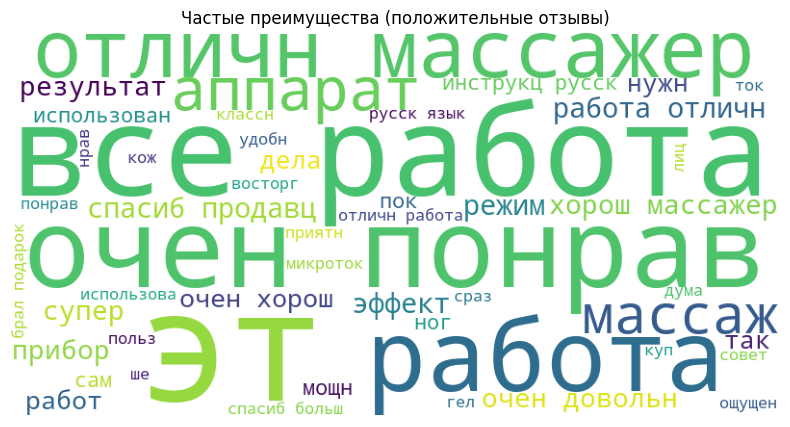

In [44]:
# Для положительных отзывов (преимущества)
all_positive = " ".join(positive['full_text_clean'])
generate_wordcloud(all_positive, 'Частые преимущества (положительные отзывы)')

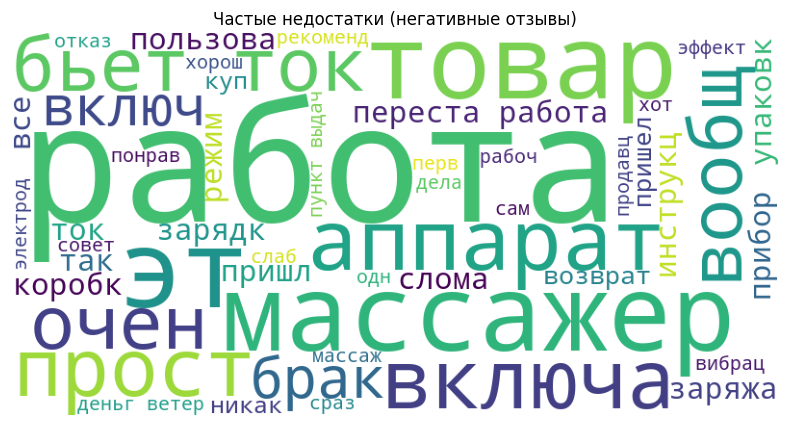

In [45]:
# Для негативных отзывов (недостатки)
all_negative = " ".join(negative['full_text_clean'])
generate_wordcloud(all_negative, 'Частые недостатки (негативные отзывы)')

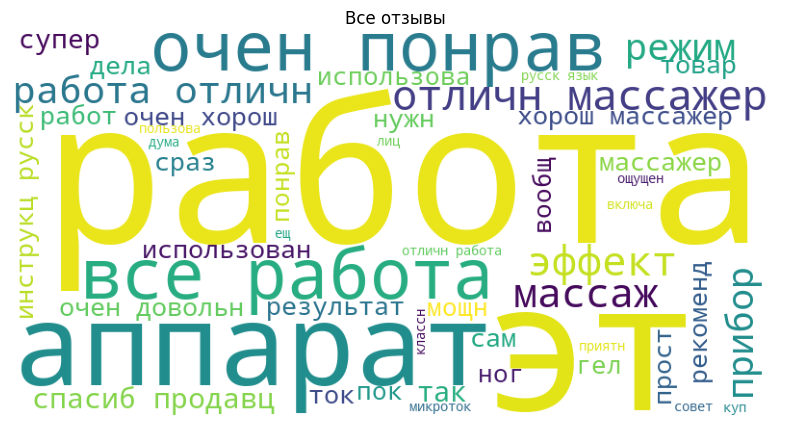

In [48]:
# Все отзывы

all_feedbacks = " ".join(df['full_text_clean'])
generate_wordcloud(all_feedbacks, 'Все отзывы')

### TF-IDF

In [ ]:
def get_tfidf_top_features(texts, n=10, use_idf=False, use_mean=True):
    tfidf = TfidfVectorizer(max_features=100, ngram_range=(1, 2))

    tfidf_matrix = tfidf.fit_transform(texts)
    feature_names = tfidf.get_feature_names_out()
    
    if use_idf:
        sorted_indices = tfidf.idf_.argsort()
        return feature_names[sorted_indices][:n].tolist()
    
    if use_mean:
        aggregated = tfidf_matrix.mean(axis=0).A1
    else:
        aggregated = tfidf_matrix.sum(axis=0).A1
    
    sorted_indices = aggregated.argsort()[::-1]  # Сортировка по убыванию
    return feature_names[sorted_indices][:n].tolist()

In [112]:
# Ключевые слова в преимуществах положительных отзывов
top_positive_adv = get_tfidf_top_features(positive['full_text_clean'])
print("Топ-10 слов (положительные отзывы, преимущества):", " ".join(top_positive_adv))

print("Топ-10 слов (положительные отзывы, преимущества):", top_positive_adv)

Топ-10 слов (положительные отзывы, преимущества): работа отличн очен массажер все хорош спасиб понрав рекоменд супер
Топ-10 слов (положительные отзывы, преимущества): ['работа', 'отличн', 'очен', 'массажер', 'все', 'хорош', 'спасиб', 'понрав', 'рекоменд', 'супер']


In [113]:
# Ключевые слова в недостатках негативных отзывов
top_negative_dis = get_tfidf_top_features(negative['full_text_clean'], n=50)
print("Топ-20 слов (негативные отзывы, недостатки):", " ".join(top_negative_dis))
print("Топ-20 слов (негативные отзывы, недостатки):", top_negative_dis)

Топ-20 слов (негативные отзывы, недостатки): работа очен пришел товар ток массажер возврат деньг коробк вообщ эт слома бьет зарядк инструкц включа прост полн переста брак аппарат одн заряжа слаб пришл сильн использован никак включ рабоч упаковк бьет ток так ден все перв быстр плох эффект минут месяц отказ подарок рекоменд режим пользова совет переста работа ветер недел
Топ-20 слов (негативные отзывы, недостатки): ['работа', 'очен', 'пришел', 'товар', 'ток', 'массажер', 'возврат', 'деньг', 'коробк', 'вообщ', 'эт', 'слома', 'бьет', 'зарядк', 'инструкц', 'включа', 'прост', 'полн', 'переста', 'брак', 'аппарат', 'одн', 'заряжа', 'слаб', 'пришл', 'сильн', 'использован', 'никак', 'включ', 'рабоч', 'упаковк', 'бьет ток', 'так', 'ден', 'все', 'перв', 'быстр', 'плох', 'эффект', 'минут', 'месяц', 'отказ', 'подарок', 'рекоменд', 'режим', 'пользова', 'совет', 'переста работа', 'ветер', 'недел']


На сколько разумно прибавлять частицу "не" для списка терминов из негативных отзывов?

In [116]:
# Для положительных отзывов
positive_descriptions = positive['advantage_clean'] + " " + positive['comment_clean']
negative_descriptions = negative['disadvantage_clean'] + " " + negative['comment_clean']

# Топ-термины
top_positive_terms = get_tfidf_top_features(positive_descriptions, n=30)
top_negative_terms = get_tfidf_top_features(negative_descriptions, n=30)

print("Топ положительных тем:", top_positive_terms)
print("Топ негативных тем:", top_negative_terms)

Топ положительных тем: ['работа', 'отличн', 'массажер', 'очен', 'хорош', 'все', 'спасиб', 'понрав', 'рекоменд', 'супер', 'аппарат', 'классн', 'подарок', 'прост', 'довольн', 'результат', 'пришел', 'режим', 'товар', 'упакова', 'пок', 'эт', 'вещ', 'эффект', 'быстр', 'продавц', 'массаж', 'все работа', 'штук', 'пришл']
Топ негативных тем: ['работа', 'очен', 'товар', 'пришел', 'ток', 'массажер', 'возврат', 'деньг', 'эт', 'коробк', 'слома', 'вообщ', 'зарядк', 'бьет', 'инструкц', 'включа', 'переста', 'прост', 'брак', 'полн', 'аппарат', 'слаб', 'заряжа', 'одн', 'сильн', 'использован', 'пришл', 'никак', 'так', 'упаковк']


In [115]:
uniq_positive_terms = get_tfidf_top_features(positive['full_text_clean'], use_idf=True)
uniq_negative_terms = get_tfidf_top_features(negative['full_text_clean'], use_idf=True)

print("Уникальные термины для положительных отзывов:", uniq_positive_terms)
print("Уникальные термины для негативных отзывов:", uniq_negative_terms)

Уникальные термины для положительных отзывов: ['работа', 'очен', 'массажер', 'отличн', 'спасиб', 'рекоменд', 'все', 'хорош', 'понрав', 'аппарат']
Уникальные термины для негативных отзывов: ['работа', 'очен', 'товар', 'ток', 'пришел', 'массажер', 'возврат', 'деньг', 'эт', 'вообщ']


добавить вывод отзывов с терминами

In [55]:
def search_term(df, search, column="full_text_clean"):
    return df[df[column].str.contains(search)]

def output_n_feedbacks(df, n):
    feedback_texts = []
    for i in df['full_text'].head(n):
        feedback_texts.append(str(i))
    return feedback_texts


count_output = 50
search = "возврат"
texts = output_n_feedbacks(search_term(negative, search), count_output)

for text in texts:
    print(f"{text.strip()}\n")

Пришёл совершенно другой товар вместо этого, поэтому возврат.

Пришёл с поцарапанным экраном, на обороте видны жирные пятна. Проверить не удалось, так как все пакеты запены,так же уточнили, что товар не возвратный.

Не работает, импульса нет, сам отключается. Заявку на возврат по браку продавец отклонил.

Получил включил неработает - возврат.

Миостимулятор не рабочий. Проверяли вместе с работником пункта выдачи. Почему не справедливо вычли 200руб.за возврат. Так продавец на нем гораздо больше заработает на возврате.

Электродов в комплекте не оказалось, пояс не включается, я очень-очень расстроилась, буду оформоять возврат.

Ничего Не подошло по размеру. Я понимаю, что худеют у нас худые, но иногда и полные хотят похудеть, а для нас не рассчитано. Но самое обидное не хотят оформлять возврат.

Длина пояса очень короткая, пользоваться не получитя, возврат отказан, бесполезный товар, деньги на ветер!

Уже второй день не работает,хочу сделать возврата

Своя зарядка кончилась,перестал заря

# Тестыыыы

In [6]:
from parser import *

# Инициализация парсера
wb_parser = WB_Parser()

# Получение списка товаров (статический метод)
# products_df = WB_Parser.get_wb_products(query="миостимулятор", pages=2)

# Получение деталей товара
try:
    product_details = wb_parser.get_product_details(91028354)
    # feedbacks = wb_parser.get_product_feedbacks(43996867)
    # print(product_details)
finally:
    # wb_parser.safe_close()
    pass

product_details

{'id': 91028354,
 'description': 'Миостимулятор импульсный массажер электрический для мышц всего тела используется для лечения, похудения, физиотерапии, тренировки, как антицеллюлитный массажер. \nВ комплекте терапевтические тапочки-электроды, перчатки-электроды, носки-электроды, напульсники нарукавники-электроды, 16 липучек электродов, 2 шнура для накладок (на 2 и 4 электрода). \nИНСТРУКЦИЯ НА РУССКОМ ЯЗЫКЕ в комплекте! Также она прикреплена в виде фото в карточке товара.\n!ОБРАТИТЕ ВНИМАНИЕ, что без прикрепления электродов к участкам тела прибор через 3 секунды автоматически отключается во избежании перегрева! \nЭлектростимулятор для всего тела JR-309 – идеальный прибор для домашней физиотерапии, лечения, реабилитации, похудения и расслабления. Теперь не нужно тратиться на дорогостоящие процедуры в медицинских центрах и массажистов! \nМиостимулятор во время работы задействует все группы мышц. С помощью электродов сами можете регулировать на какие мышцы воздействовать. \nНа обрабатыва

In [7]:
try:
    product_details = wb_parser.get_product_details(91028354)
finally:
    wb_parser.safe_close()

In [8]:
main_info, other_specs = parse_product_data(product_details)

main_info
# other_specs

,id,power_type,zones,type,description
0,91028354,220В (5А); 3 батарейки ААА; USB-шнур,ноги; пресс; тело,миостимулятор; Массажер электрический; лечение,Миостимулятор импульсный массажер электрически...


In [9]:
other_specs

,good_id,group_name,name,value
0,91028354,Основная информация,Цвет,серый
1,91028354,Общие характеристики,Модель,JR309
2,91028354,Питание,Питание,220В (5А); 3 батарейки ААА; USB-шнур
3,91028354,Технические особенности,Количество режимов работы,9
4,91028354,Дополнительная информация,Тип массажера,миостимулятор; Массажер электрический; лечение
5,91028354,Дополнительная информация,Зона массажа,ноги; пресс; тело
6,91028354,Дополнительная информация,Действие,для массажа; для тренировки мышц; для похудения
7,91028354,Дополнительная информация,Доп. опции массажера,автовыключение; электромиостимуляция; Регулиру...
8,91028354,Дополнительная информация,Комплектация,миостимулятор; тапочки - 2 шт; Перчатки - 2 шт...
9,91028354,Дополнительная информация,Страна производства,Китай


In [ ]:
# Пример использования парсера с with
with WB_Parser() as parser:
    products = parser.get_wb_products(...)
    products = parser.
    for id in products['id']:
        details = parser.get_product_details(id)
        feedbacks = parser.get_product_feedbacks(id)

In [ ]:
main_specs_df, other_specs_df = parse_product_data(details, 176410178)

In [138]:
df = pd.read_csv("../data/details_cleared_wb_products.csv")

df[["id", "name", "price", "rating", "feedbacks", "brand", "power_type", "zones"]].to_csv("t.csv", index=False)

{'description': 'Электростимулятор чрескожный универсальный Нейродэнс ПКМ — это современный физиотерапевтический аппарат, который станет надежным помощником в восстановлении и поддержании здоровья. Он предназначен для применения в домашних условиях, предоставляя возможность получать эффективные физиотерапевтические процедуры без необходимости посещения медицинских учреждений.\n\nПрибор работает на основе технологии электростимуляции, что позволяет воздействовать на мышцы, улучшая кровообращение и облегчая болевые ощущения. Устройство может использоваться для различных целей: от снятия напряжения после трудного дня до реабилитации после травм. С ним вы сможете проводить высококачественные процедуры, направленные на восстановление функциональности мышц и суставов, а также на долголетие здоровья.\n\nУниверсальный электростимулятор обладает несколькими режимами работы, которые легко переключаются в зависимости от потребностей пользователя. Компактный размер и стильный дизайн устройства позволяют его удобно использовать как в домашних условиях, так и брать с собой в поездки. Медицинский прибор оснащен простым и интуитивно понятным управлением, что делает его доступным для всех возрастных категорий.\n\nБлагодаря высококачественным материалам и современным технологиям, этот физиотерапевтический аппарат обеспечивает надежность и долгий срок службы. Нейродэнс ПКМ идеально подходит для тех, кто заботится о своем здоровье и стремится к активной жизни.\n\nС этим электростимулятором вы можете легко осуществлять заботу о своем организме, не выходя из дома. Он станет надежным партнёром в процессе восстановления и улучшения самочувствия.', 
'specifications': 
{'Общие характеристики': {'Гарантийный срок': '1 год'}, 
'Питание': {'Питание': 'от батареек'}, 
'Технические особенности': {'Количество режимов работы': '24'}, 
'Материалы': {'Материал корпуса': 'пластик'}, 
'Дополнительная информация': {'Вид воздействия': 'ток низкой частоты на определённые зоны тела', 
'Область применения': 'для всего тела', 'Противопоказания': 'индивидуальная непереносимость; наличие имплантированного кардиостимулятора', 'Комплектация': 'батарейки АА (2шт.); инструкция по эксплуатации; электростимулятор', 'Страна производства': 'Россия'}, 
'Габариты': {'Высота предмета': '4.5 см', 'Ширина предмета': '5.5 см', 'Длина предмета': '14.5 см', 'Вес товара без упаковки (г)': '350 г', 'Вес товара с упаковкой (г)': '425 г', 'Длина упаковки': '24 см', 'Высота упаковки': '9 см', 'Ширина упаковки': '17 см'}, 
'Документы': {'Регистрационное удостоверение': 'РЗН 2019/9330'}, 
'Без названия': {'': ''}}, 
'power_type': 'от батареек'}

{'description': 'Мио стимулятор для шеи - ощущение комфорта и расслабления на грани нового уровня!Приветствую! Если ты ищешь идеальное средство для максимального расслабления и ухода за своим телом, то Массажер мио стимулятор для шеи - твой идеальный выбор! Позволь мне рассказать тебе, почему этот микротоковый миостимулятор стоит твоего внимания.Помимо уникального дизайна и компактных размеров, этот электрический миостимулятор специально разработан для эффективного массажа мышц шеи, спины и воротниковой зоны. Он использует микротоки, чтобы активировать мышцы, способствуя глубокому расслаблению и оздоровлению всего тела.Вот почему Массажер электростимулятор для шеи - это революционный аппарат для миостимуляции и электрического массажа:- Миостимуляция: Уникальная технология микротоков позволит тебе нежно стимулировать мышцы, обеспечивая непревзойденное чувство расслабления и снятия напряжения.- Легкий и компактный: Благодаря своему мини размеру, этот массажер станет твоим незаменимым спутником в путешествиях и повседневной жизни. Наслаждайся массажем в любое время и в любом месте!- Беспроводной: Этот электромиостимулятор оснащен батареей, поэтому нет необходимости использовать провода. Готов к использованию в любой момент!- Многофункциональный: Не только для шеи! Этот электромассажер также отлично подходит для использования на других зонах тела, таких как воротниковая зона, часть мышц спины. Обнаружь новые возможности для ухода за собой!- Оздоровление и косметический эффект: Благодаря электростимуляции мио стимулятор поможет усилить массажный эффект и улучшить общее состояние кожи. Получи не только расслабление, но и красоту!Если ты ищешь идеальный подарок для себя или для близкого человека, то Массажер Мио стимулятор для шеи - это идеальный выбор. Не упусти возможность насладиться максимальным расслаблением и оздоровительным эффектом, просто нажми на кнопку "Добавить в корзину" прямо сейчас!', 'specifications': {'Основная информация': {'Цвет': 'зеленый; черный'}, 'Общие характеристики': {'Количество предметов в упаковке': '1 шт.'}, 'Материалы': {'Материал изделия': 'пластик'}, 'Дополнительная информация': {'Зона массажа': 'шея; воротниковая зона', 'Действие': 'микротоки; импульсы; стимулирует кровообращение и улучшает питание тканей', 'Страна производства': 'Китай', 'Комплектация': 'массажер; usb-кабель'}, 'Габариты': {'Ширина предмета': '13 см', 'Высота предмета': '15 см', 'Вес товара с упаковкой (г)': '0.3 г', 'Длина упаковки': '19 см', 'Высота упаковки': '15 см', 'Ширина упаковки': '5 см'}}, 'power_type': None, 'zones': 'шея; воротниковая зона'}

In [ ]:

# https://basket-18.wbbasket.ru/vol2918/part291888/291888914/info/ru/card.json опицональный вариант парсинга инфы о товаре


In [63]:
# random.uniform(0.1, 3)

for i in range(100):
    print(random.uniform(0.5, 1.5))

0.5935708008896233
0.9528682536263479
0.7281459139371663
0.7212937024140541
1.3612180180114044
1.3343318902111054
0.9688114318942107
1.1060621233017311
0.9258313495331713
1.2549722835066326
1.0985746803036114
1.1769997141033617
0.6039166566408797
0.7452885978940176
0.9480435178253672
0.6385073295711176
0.6124980923165215
1.2322159356590725
0.7248834323040282
0.7749586224226347
1.2988430539220255
0.8912295555059521
0.6567131591982344
0.6477734007223448
1.1024019075743505
0.851992761472716
0.5772010905996738
0.5630929824044376
0.709656650910031
1.404011351241797
0.7297474271058513
1.2325315873842713
0.8538759285494836
1.410908781719846
0.5243524410581698
1.0509435501482942
1.2465779264823658
0.7062496901543402
0.6474919983043484
0.5286273365971108
1.1119429716332494
1.3349764356906395
1.2774549954365433
0.5191761150363726
1.3683097808987947
1.404062209868552
0.8598273662449979
0.829103321438213
0.6593733630287486
0.6575632010517043
1.0032455923588754
0.72941721687951
1.154264812182317
0.